__This code implements RoBertA on MAESTRO dataset__

#### install all necessary package and mount the drive 

In [ ]:
!pip install miditok
!pip install tokenizers
!pip install setuptools_rust

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.4/94.4 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 7.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 106.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.1 MB/s eta 0:00:00


In [ ]:
# mount the google drive 
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

#### Functions to prepare input for training and testing 

In [ ]:
import miditok
import miditoolkit
from miditok import *
from pathlib import Path
import json
import torch

In [ ]:
# This function extracts the tokens generated and processed it to form dataset
def Extract_Tokens(path):
    # Extract all .json files from tokenized training set 
    midi_paths = list(Path(path).glob('**/*.json'))
    dataset = []
    for file in midi_paths:
        f = open(file)
        data = json.load(f)
        data = data['ids'][0]
        # Add a <start> token (1) at beginning of a song 
        data.insert(0,1)
        # Add a <end> token (2) at end of a song 
        data.append(2)
        # append the processed token for a song to the dataset 
        dataset.append(data)
    return dataset

Prepare the 3 inputs to the model: 
1.   __input_ids__ — token_ids with ~15% of tokens masked using the mask token \<mask\>.
2.   __attention_mask__ — a tensor of 1s and 0s, marking the position of real tokens/padding tokens — used in attention calculations.
3. __labels__ — our token_ids with no masking.

In [ ]:
def Prepare_Inputs(dataset,masked_percentage = 0.15):

    #determine the maximum length for a piece 
    num = []
    for i in range(len(dataset)):
      num.append(len(dataset[i])) 
    max_length = (max(num)//1024+1)*1024

    #Initialize the labels and mask 
    labels = torch.zeros(len(dataset),max_length)
    mask = torch.zeros(len(dataset),max_length)
    
    # Load the tokens value into labels and zero-padd the rest
    # For mask, mark the position of real position with 1, and zero the paddings 
    for i in range(len(dataset)):
      labels[i,:len(dataset[i])] = torch.Tensor(dataset[i])
      mask[i,:len(dataset[i])] = 1
    
    # Reshape teh label and mask to maximum embedding size (1024)
    labels = torch.reshape(labels,(len(dataset)*max_length//1024,1024))
    mask = torch.reshape(mask,(len(dataset)*max_length//1024,1024))
    
    # Get rid of rows with only padding 
    mask = mask[labels.sum(1)>0]
    labels = labels[labels.sum(1)>0]

    # make copy of labels tensor to be input_ids 
    input_ids = labels.detach().clone()

    # create random array of floats with equal dims to input_ids
    rand = torch.rand(input_ids.shape)

    # mask random 15% where token is not 0 [PAD], 1 [dos], or 2 [eos]
    mask_arr = (rand < masked_percentage) * (input_ids > 2)

    # loop through each row in input_ids tensor 
    for i in range(input_ids.shape[0]):
        # get indices of mask positions from mask array
        selection = torch.flatten(mask_arr[i].nonzero()).tolist()
        # mask input_ids
        input_ids[i, selection] = 3  # we set the mask token == 3
    return input_ids, mask, labels

In [ ]:
# Prepare dataset for training 
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        # store encodings internally
        self.encodings = encodings

    def __len__(self):
        # return the number of samples
        return self.encodings['input_ids'].shape[0]

    def __getitem__(self, i):
        # return dictionary of input_ids, attention_mask, and labels for index i
        return {key: tensor[i] for key, tensor in self.encodings.items()}

#### Prepare inputs for training 

In [ ]:
# extract tokens from .json files and prepare the training dataset
train_path = '/content/drive/Shareddrives/EC523_Project/CodeWorkspace/tokens_BPE_train/'
traindataset = Extract_Tokens(train_path)
# Process the training dataset to prepare 3 inputs 
input_ids, mask, labels = Prepare_Inputs(traindataset)
# prepare for training with dataloader
encodings = {'input_ids': input_ids.to(torch.int64), 'attention_mask': mask.to(torch.int64), 'labels': labels.to(torch.int64)}
train = Dataset(encodings)
trainloader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True)

#### Set up the BERT Model

In [ ]:
from transformers import RobertaConfig, RobertaForMaskedLM, AdamW
from tqdm import tqdm

config = RobertaConfig(
    vocab_size=500,  # we align this to the tokenizer vocab_size
    max_position_embeddings=1026,
    hidden_size=384,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1
)
model = RobertaForMaskedLM(config)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# and move our model over to the selected device
model.to(device)
# activate training mode
model.train()
# initialize optimizer
optim = AdamW(model.parameters(), lr=1e-4)

#### Train the dataset

In [ ]:
epochs = 5
losses = []
accumulation_steps = 16 # Accumulate gradients over 8 batches
for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    loop = tqdm(trainloader, leave=True)
    for i,batch in enumerate(loop):

        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # process
        outputs = model(input_ids, attention_mask=attention_mask,
                        labels=labels)
        # extract loss
        loss = outputs.loss
        losses.append(loss.item())
        # calculate loss for every parameter that needs grad update
        loss.backward()
        if (i+1) % accumulation_steps == 0:
        # Update parameters
            optim.step()
            optim.zero_grad()
        # update parameters
        # print relevant info to progress bar
            loop.set_description(f'Epoch {epoch}')
            loop.set_postfix(loss=sum(losses[-16:])/16)
        


Epoch 4: 100%|██████████| 3640/3640 [17:15<00:00,  3.52it/s, loss=0.772]


In [ ]:
# Saved the trained model 
model.save_pretrained('/content/drive/Shareddrives/EC523_Project/CodeWorkspace/model_BERT3')  

##### Plot the loss 

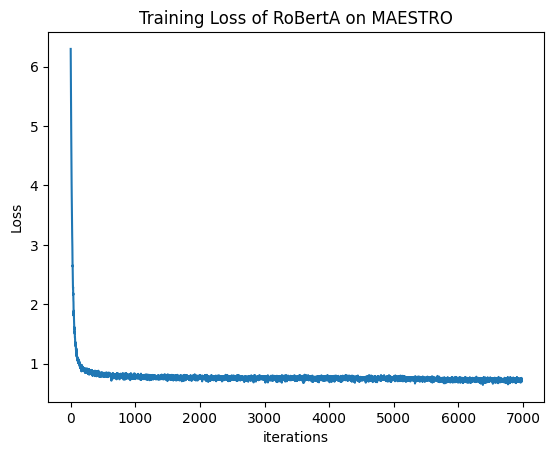

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.title('Training Loss of RoBertA on MAESTRO')
plt.show()


#### Generate new music 

In [ ]:
# Load the tokens 
token = REMI()
token.load_params('/content/drive/Shareddrives/EC523_Project/CodeWorkspace/REMItokenizer.json')

In [ ]:
# Load the trained model 
from transformers import RobertaForMaskedLM
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = RobertaForMaskedLM.from_pretrained('/content/drive/Shareddrives/EC523_Project/CodeWorkspace/model_BERT3') 
model.to(device)

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(500, 384, padding_idx=1)
      (position_embeddings): Embedding(1026, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): Lay

##### Generate dataset for generating music –– mask 50% of the dataset 

In [ ]:
# extract tokens from .json files and prepare the validation dataset
valid_path = '/content/drive/Shareddrives/EC523_Project/CodeWorkspace/tokens_BPE_valid/'
validdataset = Extract_Tokens(valid_path)
# Process the validation dataset to prepare 3 inputs; 
input_ids, mask, labels = Prepare_Inputs(validdataset,masked_percentage = 0.3)
# prepare for training with dataloader
encodings = {'input_ids': input_ids.to(torch.int64), 'attention_mask': mask.to(torch.int64)}
valid = Dataset(encodings)
validloader = torch.utils.data.DataLoader(valid, batch_size=1, shuffle=False)


##### Generate output tokens 

In [ ]:
#Initialize the output 
output = torch.Tensor(len(valid),len(valid[0]['input_ids']))
for i,batch in enumerate(validloader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    # retrieves the raw output of the model, which represents a set of scores for each possible output token 
    logits = model(input_ids, attention_mask=attention_mask).logits
    # choose the maximum output
    prediction = torch.argmax(logits, axis=-1)
    # find index of mask token 
    mask_token_index = torch.where((input_ids == 3))[0]
    # update the values of input_ids with mask to those predicted by algorithm
    input_ids[mask_token_index] = prediction[mask_token_index]
    output[i,:] = input_ids
    

##### Separate into songs and Decode the tokens back to midi file 

In [ ]:
output = output.to(torch.int64)
%cd /content/drive/Shareddrives/EC523_Project/CodeWorkspace/result/RoBertA_1024_30/
num = []
# find the length of each song 
for i in range(len(validdataset)):
  num.append(len(validdataset[i])//1024) 
# find the start and end index of each song; convert generated token back to midi
start = 0
for i,len in enumerate(num):
  input_ids = output[start:start+len]
  song = torch.flatten(input_ids)
  song_midi = token.tokens_to_midi([song.tolist()])
  filename = 'song' + str(i) + '.mid'
  song_midi.dump(filename)
  start = start+len+1

/content/drive/Shareddrives/EC523_Project/CodeWorkspace/result/RoBertA_1024_30
